In [1]:
#importing necessery libraries
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql.functions import *
from pyspark.sql.functions import split,col
from pyspark.sql.types import Row
from pyspark.sql.types import *
import json
import numpy as np
from pyspark.sql.context import SQLContext
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import MiniBatchKMeans

In [2]:
spark = SparkSession.builder.appName("Tweet analysis").getOrCreate()

#input schema is in text form
text_schema = StructType([StructField('text', StringType(), True)])
#output schema is dataframe with 2 String columns(Feature0 and Feature1)
json_schema = MapType(StringType(), StringType())

tweet_df= spark.readStream.format("socket").option("host", "localhost").option("port",6100).load()
#input dataframe schema
tweet_df.printSchema()
tweet_df1= tweet_df.selectExpr("CAST(value AS STRING)")

tweetdf2=tweet_df1.withColumn('json',from_json(col('value'),json_schema)).select(explode(col('json')))
tweetdf3=tweetdf2.withColumn('value',from_json(col('value'),json_schema)).withColumn('feature0',col('value.feature0')).withColumn('feature1',col('value.feature1')).drop('value')
#output dataframe schema
tweetdf3.printSchema()

21/12/06 21:08:43 WARN Utils: Your hostname, pes1ug19cs384-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
21/12/06 21:08:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/12/06 21:08:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/06 21:08:48 WARN TextSocketSourceProvider: The socket source should not be used for production applications! It does not support recovery.


root
 |-- value: string (nullable = true)

root
 |-- key: string (nullable = false)
 |-- feature0: string (nullable = true)
 |-- feature1: string (nullable = true)



In [3]:
#function to preprocess the dataframe
def pre_process(tdf):
    #Null values are dropped
    tdf = tdf.na.replace('', None)
    tdf = tdf.na.drop()  
    #twitter handles are filtered
    tdf = tdf.withColumn('feature1', regexp_replace('feature1',r'@\w+',''))
    #Dates are filtered
    tdf = tdf.withColumn('feature1', regexp_replace('feature1',r'\d\w+',''))
    #Special characters and numbers are filtered
    tdf = tdf.withColumn('feature1', regexp_replace('feature1','[^A-Za-z\s]',''))
    #http links are filtered
    tdf = tdf.withColumn('feature1', regexp_replace('feature1',r'http\S+',''))
    return tdf

In [4]:
acc_model1,acc_model2,pre_model1,pre_model2,rec_model1,rec_model2,score = [],[],[],[],[],[],[]

In [6]:
#num variable counts the number of batches (to differentiate between train and test)
num=0
#model initializations
model1 = SGDClassifier(loss='log')
model2 = PassiveAggressiveClassifier(C=0.5)
model5 = MiniBatchKMeans(n_clusters=20,init="k-means++",batch_size=1000)
acc1, acc2, pre1, pre2,rec1,rec2, sc = [],[],[],[],[],[],[]

#Function that performs classification using SGD and PassiveAggressive Classifiers
def classify(df):    
    global num
    num+=1 
    #list of tweets for each batch
    arr = [row['feature1'] for row in df.collect()]
    #list of target labels for each batch
    tar = [row['feature0'] for row in df.collect()]
    vectorizer = HashingVectorizer(n_features=2**15)
    x=None
    if arr:
        x = vectorizer.transform(arr)
        if num <= 10:
            model1.partial_fit(x,tar,classes=['0','4'])
            model2.partial_fit(x,tar,classes=['0','4'])
        else:
            y_pred1 = model1.predict(x)
            y_pred2 = model2.predict(x)
            tn1, fp1, fn1, tp1 = confusion_matrix(tar,y_pred1).ravel()
            tn2, fp2, fn2, tp2 = confusion_matrix(tar,y_pred2).ravel()
            acc1.append((tn1+tp1)/(tp1+tn1+fn1+fp1))
            acc2.append((tn2+tp2)/(tp2+tn2+fn2+fp2))
            pre1.append(tp1/(tp1+fp1))
            pre2.append(tp2/(tp2+fp2))
            rec1.append(tp1/(tp1+fn1))
            rec2.append(tp2/(tp2+fn2))
            print(acc1,acc2)

#Function that performs MiniBatch K-means
def cluster(df):
    global num
    num+=1
    arr = [row['feature1'] for row in df.collect()]
    tar = [row['feature0'] for row in df.collect()]
    vectorizer = TfidfVectorizer(
            max_features=10000,
            use_idf = True,
            stop_words='english')
    svd = TruncatedSVD(n_components=5)
    n = Normalizer()
    vec = make_pipeline(svd,n)
    
    if arr:
        q = vectorizer.fit_transform(arr)
        w = vec.fit_transform(q)
        if num <= 10:
            model5.partial_fit(w)
        else:
            #sc.append(model5.score(w))
            print(model5.score(w))

#Helper function to choose between CLasssification and Clustering tasks
def p(b,id):
    df = pre_process(b)
    cluster(df)
    classify(df)

query = tweetdf3.writeStream.foreachBatch(p).start()
query.awaitTermination()

21/12/06 21:12:30 WARN StreamingQueryManager: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-aacfc3a1-9219-440e-84b3-e1f1355151e0. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.


-816.0208808302714
-944.902777898627
-660.6920970978645
-1176.5786749050524
-660.7330585847893


KeyboardInterrupt: 

In [26]:
#calculating precision, recall and accuracy for models 1 and 2
s1,s2,s3,s4,s5,s6 = 0,0,0,0,0,0
for i in range(len(acc1)):
    s1 += acc1[i]
    s2 += acc2[i]
    s3 += pre1[i]
    s4 += pre2[i]
    s5 += rec1[i]
    s6 += rec2[i]
    
acc_model1.append(s1/len(acc1))
acc_model2.append(s2/len(acc1))
pre_model1.append(s3/len(acc1))
pre_model2.append(s4/len(acc1))
rec_model1.append(s5/len(acc2))
rec_model2.append(s6/len(acc1))
print(acc_model1)
print(acc_model2)
print(pre_model1)
print(pre_model2)
print(rec_model1)
print(rec_model2)

[0.7611203054906761, 0.7615185185185188, 0.7607853994328276, 0.7607857142857144, 0.7618518518518519, 0.7605568181818183]
[0.762589416577071, 0.7672222222222222, 0.7675972700422438, 0.7555000000000001, 0.765074074074074, 0.7701477272727273]
[0.75080069242965, 0.7505143594922647, 0.7538175150305515, 0.748670064543205]
[0.7593790555127204, 0.7140689607836544, 0.7715452389910149, 0.782229835989548]
[0.7761832689471054, 0.7763290921255855, 0.7743502183384681, 0.779342752272259]
[0.7792113555546772, 0.8466380353280908, 0.7499880508206438, 0.7442740167185814]


In [13]:
#calculating F1-Score for model1 and model2
f_model1,f_model2 = [],[]
for i in range(len(pre_model1)):
    f_model1.append((2*pre_model1[i] * rec_model1[i])/(pre_model1[i]+rec_model1[i]))
    f_model2.append(2*(pre_model2[i] * rec_model2[i])/(pre_model2[i]+rec_model2[i]))

In [52]:
# Calculating K-means Score
s=0
for i in range(len(sc)):
    s+=sc[i]
score.append(s/len(sc))
score

[-3614.3165684975515,
 -3053.3925244180164,
 -2552.831484594042,
 -2462.809128594015,
 -2184.5952700797475,
 -2071.732442652174,
 -1322.7841297703794]

In [7]:
t = [126,43,25,18,14,11]
batch_size = [1000,3000,5000,7000,9000,11000]
acc_model1=[0.7611203054906761, 0.7615185185185188, 0.7607853994328276, 0.7607857142857144, 0.7618518518518519, 0.7605568181818183]
acc_model2=[0.762589416577071, 0.7672222222222222, 0.7675972700422438, 0.7555000000000001, 0.765074074074074, 0.7701477272727273]
pre_model1=[0.75080069242965, 0.7505143594922647, 0.7538175150305515, 0.748670064543205]
pre_model2=[0.7593790555127204, 0.7140689607836544, 0.7715452389910149, 0.782229835989548]
rec_model1=[0.7761832689471054, 0.7763290921255855, 0.7743502183384681, 0.779342752272259]
rec_model2=[0.7792113555546772, 0.8466380353280908, 0.7499880508206438, 0.7442740167185814]

In [8]:
import matplotlib.pyplot as plt

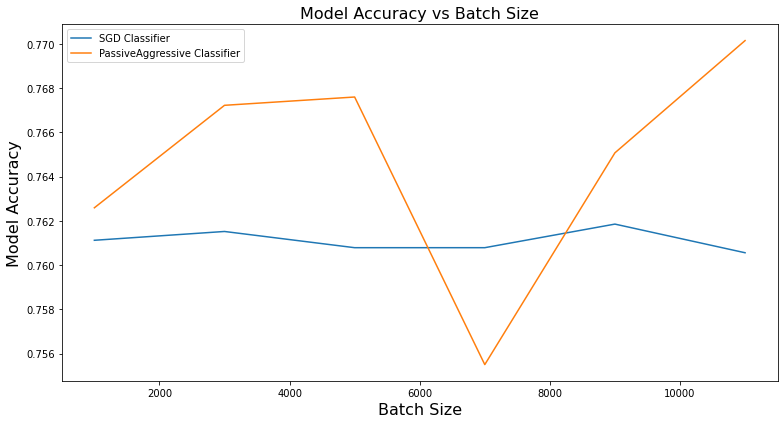

In [9]:
#Model Accuracy vs Batch Size
fig, ax = plt.subplots(figsize=(11,6))
ax.plot(batch_size,acc_model1,label='SGD Classifier')
ax.plot(batch_size,acc_model2, label='PassiveAggressive Classifier')
ax.legend()
ax.set_xlabel('Batch Size', fontsize=16)
ax.set_ylabel('Model Accuracy', fontsize=16)
ax.set_title('Model Accuracy vs Batch Size', fontsize=16)
fig.tight_layout()

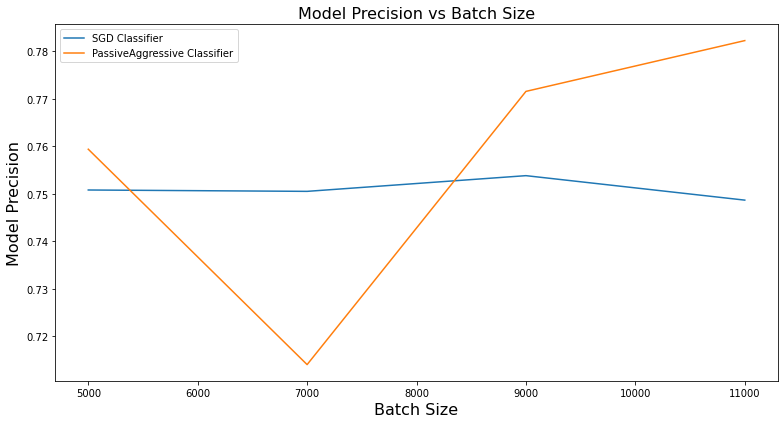

In [10]:
#Model Presicion vs Batch Size
fig, ax = plt.subplots(figsize=(11,6))
ax.plot(batch_size[2:],pre_model1,label='SGD Classifier')
ax.plot(batch_size[2:],pre_model2, label='PassiveAggressive Classifier')
ax.legend()
ax.set_xlabel('Batch Size', fontsize=16)
ax.set_ylabel('Model Precision', fontsize=16)
ax.set_title('Model Precision vs Batch Size', fontsize=16)
fig.tight_layout()

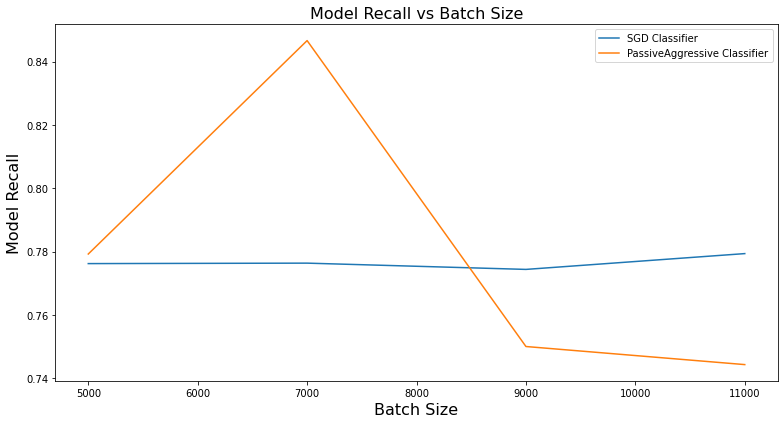

In [11]:
#Model Recall vs Batch Size
fig, ax = plt.subplots(figsize=(11,6))
ax.plot(batch_size[2:],rec_model1,label='SGD Classifier')
ax.plot(batch_size[2:],rec_model2, label='PassiveAggressive Classifier')
ax.legend()
ax.set_xlabel('Batch Size', fontsize=16)
ax.set_ylabel('Model Recall', fontsize=16)
ax.set_title('Model Recall vs Batch Size', fontsize=16)
fig.tight_layout()

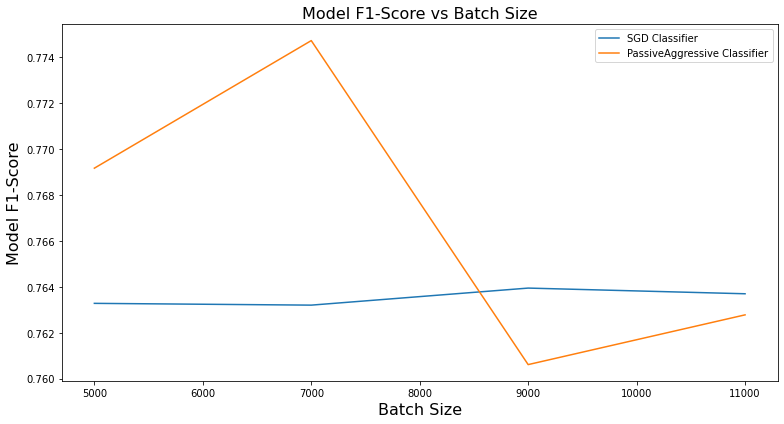

In [14]:
#Model F1-Score vs Batch Size 
fig, ax = plt.subplots(figsize=(11,6))
ax.plot(batch_size[2:],f_model1,label='SGD Classifier')
ax.plot(batch_size[2:],f_model2, label='PassiveAggressive Classifier')
ax.legend()
ax.set_xlabel('Batch Size', fontsize=16)
ax.set_ylabel('Model F1-Score', fontsize=16)
ax.set_title('Model F1-Score vs Batch Size', fontsize=16)
fig.tight_layout()

In [15]:
n_clusters=[2,3,4,5,6,7,20]
score = [-3614.3165684975515, -3053.3925244180164, -2552.831484594042, -2462.809128594015, -2184.5952700797475, -2071.732442652174,-1322.7841297703794]

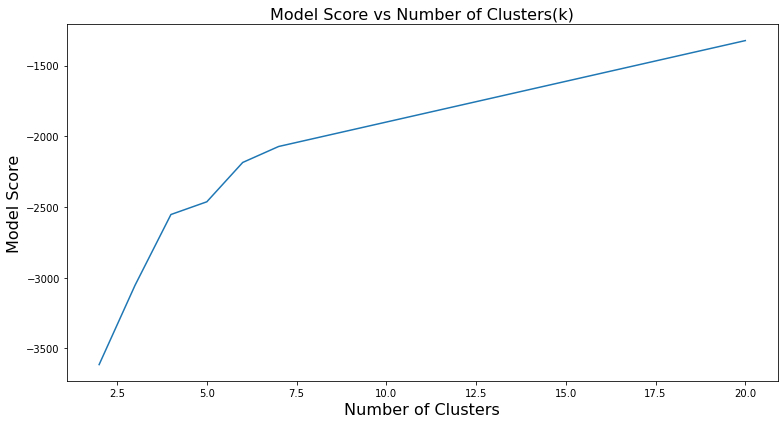

In [16]:
#Model Score vs Number of Clusters
fig, ax = plt.subplots(figsize=(11,6))
ax.plot(n_clusters,score)
ax.set_xlabel('Number of Clusters', fontsize=16)
ax.set_ylabel('Model Score', fontsize=16)
ax.set_title('Model Score vs Number of Clusters(k)', fontsize=16)
fig.tight_layout()

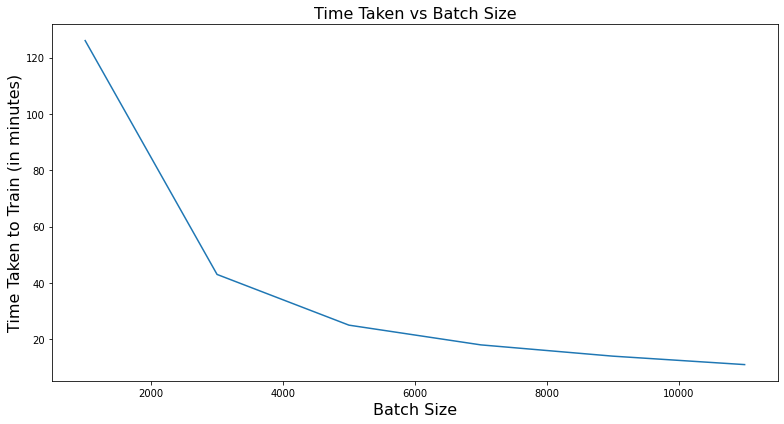

In [32]:
#Time Taken vs batch Size
fig, ax = plt.subplots(figsize=(11,6))
ax.plot(batch_size,t)
ax.set_xlabel('Batch Size', fontsize=16)
ax.set_ylabel('Time Taken to Train (in minutes)', fontsize=16)
ax.set_title('Time Taken vs Batch Size', fontsize=16)
fig.tight_layout()